# Machine Learning Engineer Nanodegree
## Capstone Project
## Project: Bitcoin Prices' prediction using neural networks

## Getting Started

The target of this project will be to provide an analytic vision of bitcoin's market behaviour by trying to forecast 
the prices of this cryptocurrency over time.   

## Exploring the Data

In [1]:
from input_output.file import FileIO
from model.gru import ModelBuilder
from visualization.plot import DataVisualization
from IPython.display import display

import json as js
import pandas as pd

__CONF_DATA = {
    "data": {
        "filename_btc": "data/bitstampUSD_1-min_data_2012-01-01_to_2018-06-27.csv",
        "train_filename_btc_clean": "data/clean_bc_trainig_data-h5", 
        "test_filename_btc_clean": "data/clean_bc_test_data-h5",
        "predictions_file": "data/predictions-h5",
        "util_columns": [
            "Open",
            "Close",
            "Weighted_Price",
            "Volume_(BTC)",
            "Volume_(Currency)"
        ],
        "batch_size": 32,
        "train_data_split": 0.8,
        "validation_data_split": 0.1,
        "x_window_size": 24,
        "y_window_size": 1,
        "target_column": "Close"
    },
    "model": {
        "epochs": 50,
        "loss_function": "mse",
        "optimizer_function": "Nadam",
        "activation_function": "tanh",
        "filename_generated_model": "data/gru_model-h5"
    }
}

Using TensorFlow backend.


In [2]:
#We will read our configuration file
conf_data = __CONF_DATA["data"]
conf_model = __CONF_DATA["model"]

#As we are dealing with time series, we will use the timestamp as our 
#index
data = pd.read_csv(conf_data["filename_btc"], index_col=0)
data.info()

#We will instantiate the needed classes to create the
#model
data_vis = DataVisualization()
file_processor = FileIO()
model_builder = ModelBuilder()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3405857 entries, 1325317920 to 1530057600
Data columns (total 7 columns):
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtypes: float64(7)
memory usage: 207.9 MB


/anaconda3/envs/capstone-lab/lib/python3.6/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
data_vis.describe_data(data)

This is the shape of the data. We have 3405857 data Points with 7 variables each.
Description of the data: 


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
count,3.405857e+06,3.405857e+06,3.405857e+06,3.405857e+06,3.405857e+06,3.405857e+06,3.405857e+06
mean,1.535757e+03,1.537163e+03,1.534153e+03,1.535739e+03,1.101862e+01,1.533527e+04,1.535645e+03
std,3.037551e+03,3.041014e+03,3.033519e+03,3.037511e+03,3.500616e+01,7.259934e+04,3.037272e+03
min,3.800000e+00,3.800000e+00,1.500000e+00,1.500000e+00,0.000000e+00,0.000000e+00,3.800000e+00
25%,1.228200e+02,1.228900e+02,1.227600e+02,1.228100e+02,4.767414e-01,7.732200e+01,1.228200e+02
50%,4.167300e+02,4.168700e+02,4.165600e+02,4.167200e+02,2.157220e+00,4.738905e+02,4.167000e+02
75%,8.094000e+02,8.099700e+02,8.089900e+02,8.094800e+02,8.931947e+00,4.197468e+03,8.093700e+02
max,1.966576e+04,1.966600e+04,1.964996e+04,1.966575e+04,5.853852e+03,5.483271e+06,1.966330e+04


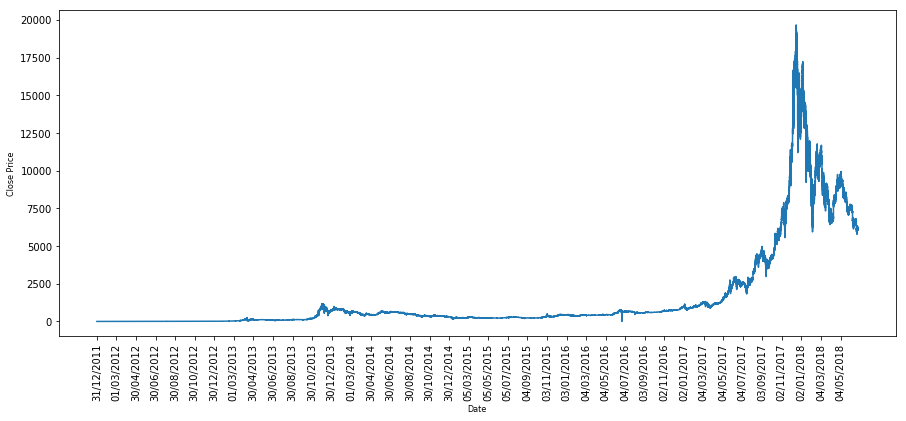

In [4]:
data_vis.plot_data(data)

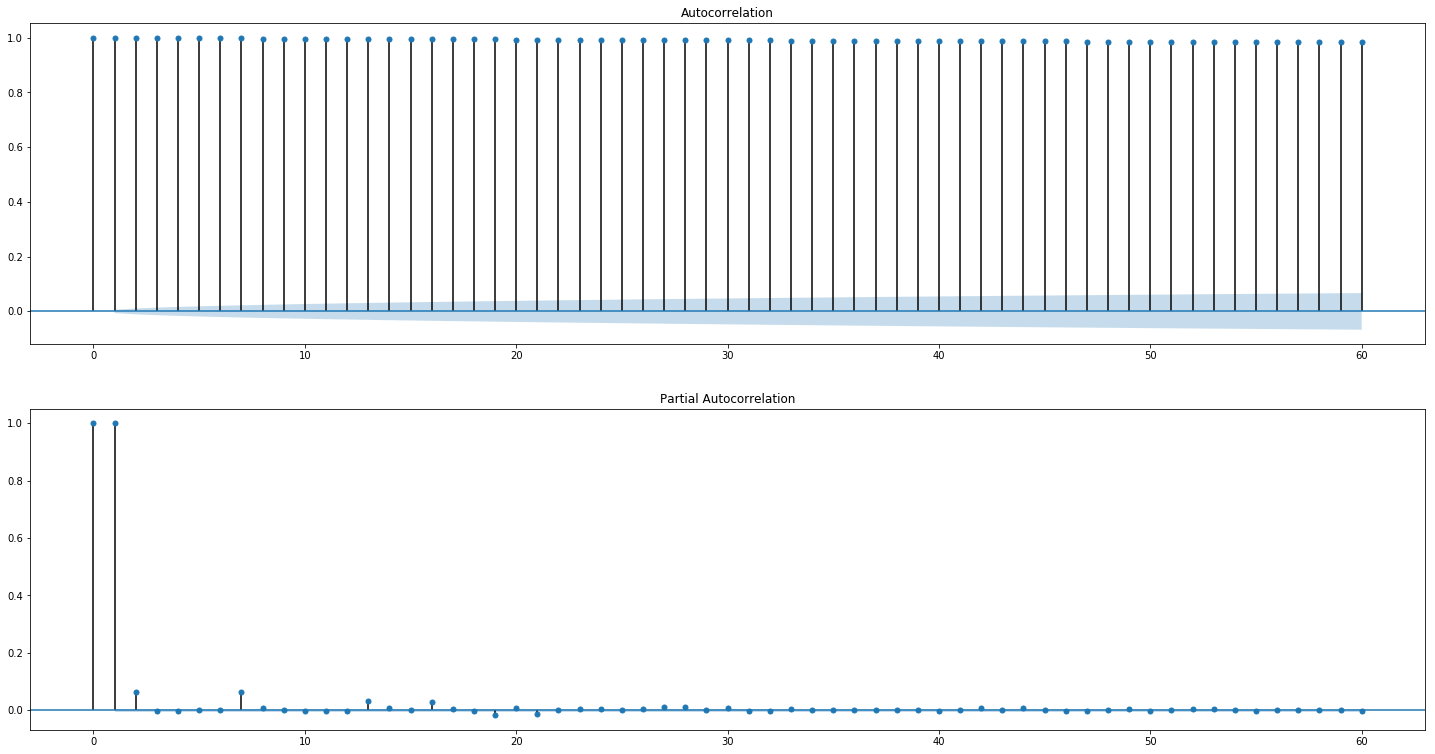

In [3]:
data_vis.data_correlation(data)

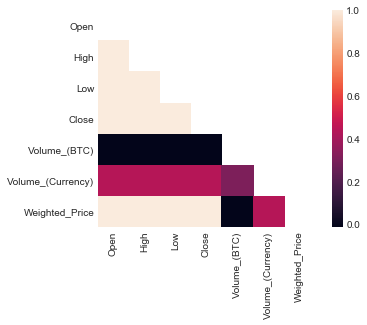

In [4]:
data_vis.variables_correlation(data)

## Data Preprocessing

In [3]:
#This method will create two data files. One containing the training set, and the other
#the testing set as specified in the configuration.
file_processor.generate_data_files(data, conf_data)

Values head: 


,Open,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,
1325317920,4.39,4.39,0.455581,2.0,4.39
1325317980,4.39,4.39,0.455581,2.0,4.39
1325318040,4.39,4.39,0.455581,2.0,4.39
1325318100,4.39,4.39,0.455581,2.0,4.39
1325318160,4.39,4.39,0.455581,2.0,4.39


Values tail: 


,Open,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,
1530057360,6061.61,6079.52,2.358001,14326.055851,6075.509043
1530057420,6078.44,6071.83,13.946659,84697.288617,6072.944713
1530057480,6079.15,6084.69,5.174984,31447.423127,6076.815504
1530057540,6082.21,6068.00,14.482301,88000.380333,6076.408637
1530057600,6073.99,6070.79,23.511004,142706.803850,6069.787707


Values head grouped by hour: 


,Open,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,
2011-12-31 07:00:00,4.39,4.39,0.455581,2.0,4.39
2011-12-31 08:00:00,4.39,4.39,0.455581,2.0,4.39
2011-12-31 09:00:00,4.39,4.39,0.455581,2.0,4.39
2011-12-31 10:00:00,4.39,4.39,0.455581,2.0,4.39
2011-12-31 11:00:00,4.39,4.39,0.455581,2.0,4.39


Values tail grouped by hour: 


,Open,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,
2018-06-26 20:00:00,6184.246000,6185.428833,2.671384,16516.025843,6184.238245
2018-06-26 21:00:00,6188.681000,6188.747333,4.174368,25952.145907,6188.370752
2018-06-26 22:00:00,6157.884167,6157.510667,10.214327,62783.866637,6157.226988
2018-06-26 23:00:00,6113.186000,6112.440833,11.233549,68410.687580,6111.864581
2018-06-27 00:00:00,6073.990000,6070.790000,23.511004,142706.803850,6069.787707


Generated data file for the training of the model:  data/clean_bc_trainig_data-h5
Generated data file for the testing of the model:  data/clean_bc_test_data-h5


## Model Configuration

In [4]:
model = None
train_data = None
validation_data = None

In [5]:
hf_train = file_processor.handle_data_file(conf_data["train_filename_btc_clean"], 'r')
# Total size of our training dataset, x_window_size, number of features
size_training_data = hf_train["x_data"].shape[0]
x_window_size = hf_train["x_data"].shape[1]
number_input_features = hf_train["x_data"].shape[2]
print("size_training_data: ", size_training_data)

# We will use a split of our trainig set as validation
# data.
validation_data_size = int(size_training_data * conf_data["validation_data_split"])
end_train_index = size_training_data - validation_data_size
# Retrieval of our training set
train_data = file_processor.retrieve_data_from_file(
    hf_train, 
    conf_data["batch_size"],
    end_index=end_train_index 
)
# Retrieval of our validation data
validation_data = file_processor.retrieve_data_from_file(
    hf_train,
    conf_data["batch_size"],
    start_index=end_train_index,
    end_index=size_training_data
)

size_training_data:  45472


In [6]:
# Calculating the number of steps per epoch for the training. In this case,
# I would chose the size of the training set / n_epochs / batch size.        
steps_per_epoch = int(end_train_index / conf_model["epochs"] / conf_data["batch_size"])
# We will do the same to calculate the validation steps
validation_steps = int(validation_data_size / conf_model["epochs"] / conf_data["batch_size"])
conf_model["steps_per_epoch"] = steps_per_epoch
conf_model["validation_steps"] = validation_steps
print(conf_model)
# We build our GRU model with the number of hidden units for each of the
# layers
layers = [number_input_features, 128, 128, 128, 1]
model = model_builder.build_gru_model(layers, conf_model, conf_data)

{'epochs': 50, 'loss_function': 'mse', 'optimizer_function': 'Nadam', 'activation_function': 'tanh', 'filename_generated_model': 'data/gru_model-h5', 'steps_per_epoch': 25, 'validation_steps': 2}
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 24, 128)           51456     
_________________________________________________________________
gru_2 (GRU)                  (None, 24, 128)           98688     
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               98688     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 248,961
Trainable params: 248,961
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [7]:
# Training of our model
history = model_builder.train_model(model, train_data, validation_data, conf_model)

Epoch 1/50
25/25 [==============================] - 4s 162ms/step - loss: 0.0324 - val_loss: 2.0027e-04
Epoch 2/50
25/25 [==============================] - 2s 71ms/step - loss: 0.0084 - val_loss: 7.4859e-04
Epoch 3/50
25/25 [==============================] - 2s 71ms/step - loss: 0.0013 - val_loss: 2.3572e-04
Epoch 4/50
25/25 [==============================] - 2s 73ms/step - loss: 5.9326e-04 - val_loss: 1.6985e-04
Epoch 5/50
25/25 [==============================] - 2s 73ms/step - loss: 6.3090e-04 - val_loss: 4.8788e-04
Epoch 6/50
25/25 [==============================] - 2s 72ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 7/50
25/25 [==============================] - 2s 72ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 8/50
25/25 [==============================] - 2s 74ms/step - loss: 0.0017 - val_loss: 5.8384e-05
Epoch 9/50
25/25 [==============================] - 2s 77ms/step - loss: 8.8796e-04 - val_loss: 8.7251e-04
Epoch 10/50
25/25 [==============================] - 2s 74ms/step - 

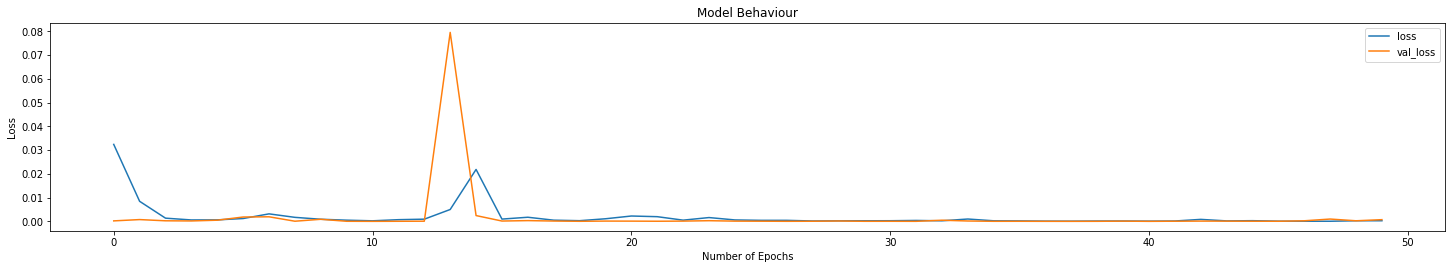

In [8]:
#Visualization of the loss and val_loss functions' performance
data_vis.plot_model_loss(history)

## Model Testing

In [15]:
from itertools import tee

hf_test = file_processor.handle_data_file(conf_data["test_filename_btc_clean"], 'r')

# Total size of our testing dataset
size_testing_data = hf_test["x_data"].shape[0]
test_steps = int(size_testing_data / conf_data['batch_size'])
conf_model["test_steps"] = test_steps
print("Size testing data: ", size_testing_data)

# We will retrieve our testing data
testing_data = file_processor.retrieve_data_from_file(
    hf_test, 
    conf_data["batch_size"],
    end_index=size_testing_data 
)
# We need to iterate over the generator twice
testing_data, testing_data_backup = tee(testing_data)

Size testing data:  11328


In [11]:
# We generate the predictions obtained from our model
predictions = model_builder.generate_predictions(conf_model, testing_data)
print("Predictions size: ", len(predictions))
hf_pred = file_processor.handle_data_file(conf_data["predictions_file"], 'w')
#We will save the predictions in a file
file_processor.save_simple_data_file(hf_pred, predictions, "predictions")

Predictions size:  11328


## Metrics and Performance

In [16]:
from math import sqrt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

predictions = np.concatenate(
        file_processor.handle_data_file(conf_data["predictions_file"], 'r')["predictions"][:]
    ).ravel().tolist()
#Calculate error and plot results
real_data = list()
for _, y in testing_data_backup:
    real_data += list(y)

print("Real Data Size: ", len(real_data))
mse = mean_squared_error(real_data, predictions)
#The RMSE is just the route of the mse
rmse = sqrt(mse)

print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)

abs_error = mean_absolute_error(real_data, predictions)
print("Mean Absolute Error: ", abs_error)


Real Data Size:  11328
Mean Squared Error:  0.000255399661812909
Root Mean Squared Error:  0.01598122842002169
Mean Absolute Error:  0.010926144364901426


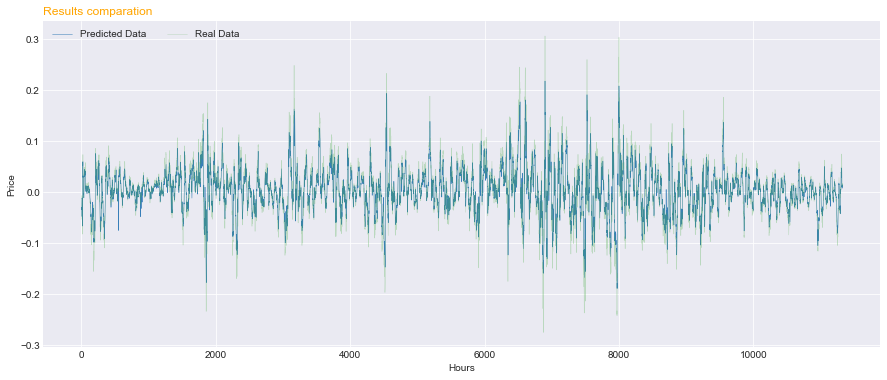

In [17]:
#Plot of the regression against the true data
data_vis.plot_results_against_true_data(predictions, real_data)